In [1]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import tensorflow
import seaborn as sns
import xgboost
import catboost
import lightgbm
import keras
%matplotlib inline

/home/tanmoy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [2]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

In [3]:
train.head()

,ID,datetime,temperature,var1,pressure,windspeed,var2,electricity_consumption
0,0,2013-07-01 00:00:00,-11.4,-17.1,1003.0,571.910,A,216.0
1,1,2013-07-01 01:00:00,-12.1,-19.3,996.0,575.040,A,210.0
2,2,2013-07-01 02:00:00,-12.9,-20.0,1000.0,578.435,A,225.0
3,3,2013-07-01 03:00:00,-11.4,-17.1,995.0,582.580,A,216.0
4,4,2013-07-01 04:00:00,-11.4,-19.3,1005.0,586.600,A,222.0


In [4]:
test.head()

,ID,datetime,temperature,var1,pressure,windspeed,var2
0,552,2013-07-24 00:00:00,-10.0,-16.4,1011.0,263.280,A
1,553,2013-07-24 01:00:00,-10.0,-20.7,1011.0,267.175,A
2,554,2013-07-24 02:00:00,-10.7,-17.1,1003.0,269.555,A
3,555,2013-07-24 03:00:00,-13.6,-20.7,1008.0,273.060,A
4,556,2013-07-24 04:00:00,-10.7,-17.1,1006.0,1.765,A


## Data Exploration

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 8 columns):
ID                         26496 non-null int64
datetime                   26496 non-null object
temperature                26496 non-null float64
var1                       26496 non-null float64
pressure                   26496 non-null float64
windspeed                  26496 non-null float64
var2                       26496 non-null object
electricity_consumption    26496 non-null float64
dtypes: float64(5), int64(1), object(2)
memory usage: 1.6+ MB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8568 entries, 0 to 8567
Data columns (total 7 columns):
ID             8568 non-null int64
datetime       8568 non-null object
temperature    8568 non-null float64
var1           8568 non-null float64
pressure       8568 non-null float64
windspeed      8568 non-null float64
var2           8568 non-null object
dtypes: float64(4), int64(1), object(2)
memory usage: 468.6+ KB


In [7]:
train.isnull().sum()

ID                         0
datetime                   0
temperature                0
var1                       0
pressure                   0
windspeed                  0
var2                       0
electricity_consumption    0
dtype: int64

In [8]:
test.isnull().sum()

ID             0
datetime       0
temperature    0
var1           0
pressure       0
windspeed      0
var2           0
dtype: int64

## Data Preprocessing

### Datetime

In [9]:
train.datetime=pd.to_datetime(train.datetime)
test.datetime=pd.to_datetime(test.datetime)

In [10]:
train.head()

,ID,datetime,temperature,var1,pressure,windspeed,var2,electricity_consumption
0,0,2013-07-01 00:00:00,-11.4,-17.1,1003.0,571.910,A,216.0
1,1,2013-07-01 01:00:00,-12.1,-19.3,996.0,575.040,A,210.0
2,2,2013-07-01 02:00:00,-12.9,-20.0,1000.0,578.435,A,225.0
3,3,2013-07-01 03:00:00,-11.4,-17.1,995.0,582.580,A,216.0
4,4,2013-07-01 04:00:00,-11.4,-19.3,1005.0,586.600,A,222.0


#### Extracting informations(Year,Month, Week, Day, Hour, Quarter, Day of the Year) from Datetime object.

In [11]:
#Train Data
train["year"]=train.datetime.apply(lambda x: x.year)
train["month"]=train.datetime.apply(lambda x: x.month)
train["week"]=train.datetime.apply(lambda x: x.week)
train["day"]=train.datetime.apply(lambda x: x.day)
train["hour"]=train.datetime.apply(lambda x: x.hour)
train["quarter"]=train.datetime.apply(lambda x: x.quarter)
train["dayofyear"]=train.datetime.apply(lambda x: x.dayofyear)

In [12]:
#Test Data
test["year"]=test.datetime.apply(lambda x: x.year)
test["month"]=test.datetime.apply(lambda x: x.month)
test["week"]=test.datetime.apply(lambda x: x.week)
test["day"]=test.datetime.apply(lambda x: x.day)
test["hour"]=test.datetime.apply(lambda x: x.hour)
test["quarter"]=test.datetime.apply(lambda x: x.quarter)
test["dayofyear"]=test.datetime.apply(lambda x: x.dayofyear)

### Difference of days is calculated by taking first day(2013-07-01) of the given dataset.
>(Formula Used): absolute((2013-Year))X365 + absolute((7-Month))X30 + absolute(1-Day)

In [13]:
train["day_diff"]=np.abs((2013-train.datetime.dt.year)*365)+np.abs((7-train.datetime.dt.month)*30)+np.abs((1-train.datetime.dt.day))

In [14]:
test["day_diff"]=np.abs((2013-test.datetime.dt.year)*365)+np.abs((7-test.datetime.dt.month)*30)+np.abs((1-test.datetime.dt.day))

In [15]:
train.head()

,ID,datetime,temperature,var1,pressure,windspeed,var2,electricity_consumption,year,month,week,day,hour,quarter,dayofyear,day_diff
0,0,2013-07-01 00:00:00,-11.4,-17.1,1003.0,571.910,A,216.0,2013,7,27,1,0,3,182,0
1,1,2013-07-01 01:00:00,-12.1,-19.3,996.0,575.040,A,210.0,2013,7,27,1,1,3,182,0
2,2,2013-07-01 02:00:00,-12.9,-20.0,1000.0,578.435,A,225.0,2013,7,27,1,2,3,182,0
3,3,2013-07-01 03:00:00,-11.4,-17.1,995.0,582.580,A,216.0,2013,7,27,1,3,3,182,0
4,4,2013-07-01 04:00:00,-11.4,-19.3,1005.0,586.600,A,222.0,2013,7,27,1,4,3,182,0


In [16]:
train=train[["ID","day_diff","year","quarter",'month','week',"dayofyear",'day','hour','temperature','var1','pressure','windspeed','var2','electricity_consumption']]

In [17]:
test=test[["ID","day_diff","year","quarter",'month','week','dayofyear','day','hour','temperature','var1','pressure','windspeed','var2']]

## Temperature

In [18]:
train.head()

,ID,day_diff,year,quarter,month,week,dayofyear,day,hour,temperature,var1,pressure,windspeed,var2,electricity_consumption
0,0,0,2013,3,7,27,182,1,0,-11.4,-17.1,1003.0,571.910,A,216.0
1,1,0,2013,3,7,27,182,1,1,-12.1,-19.3,996.0,575.040,A,210.0
2,2,0,2013,3,7,27,182,1,2,-12.9,-20.0,1000.0,578.435,A,225.0
3,3,0,2013,3,7,27,182,1,3,-11.4,-17.1,995.0,582.580,A,216.0
4,4,0,2013,3,7,27,182,1,4,-11.4,-19.3,1005.0,586.600,A,222.0


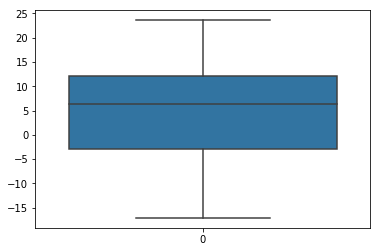

In [19]:
sns.boxplot(data=train.temperature)

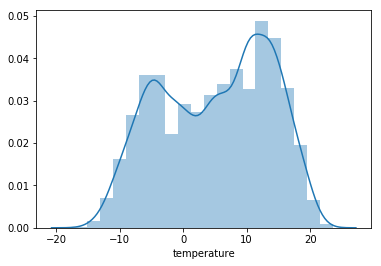

In [20]:
sns.distplot(a=train.temperature,bins=20)

In [21]:
train.temperature.describe()

count    26496.000000
mean         5.098989
std          8.682860
min        -17.100000
25%         -2.900000
50%          6.400000
75%         12.100000
max         23.600000
Name: temperature, dtype: float64

From above , we can conclude Temprature is highly affected by outliers.

In [33]:
train.groupby(by=['year','month']).median()['temperature']

year  month
2013  7        -7.9
      8        -5.7
      9         0.7
      10        7.1
      11       10.0
      12       14.3
2014  1        15.0
      2        14.3
      3        10.0
      4         6.4
      5         1.4
      6        -5.0
      7        -7.1
      8        -6.4
      9        -1.4
      10        7.1
      11       11.4
      12       13.6
2015  1        15.0
      2        14.3
      3        11.4
      4         5.7
      5        -0.7
      6        -7.1
      7        -7.9
      8        -5.7
      9        -0.7
      10        3.6
      11       11.4
      12       12.1
2016  1        15.0
      2        15.7
      3        10.7
      4         6.4
      5         0.7
      6        -5.0
      7        -5.0
      8        -5.0
      9         2.1
      10        7.9
      11       10.7
      12       12.9
2017  1        16.4
      2        14.3
      3        10.7
      4         5.7
      5         0.0
      6        -5.0
Name: temperature, dtype: fl

 #### If we look at above data, we can see temprature is following seasonality. Based on data,I created 3 different categories.

In [28]:
## Temperature Category 

def Temp_Category(x):
    p=[11,12,1,2,3]
    q=[4,10]
    r=[5,6,7,8,9]
    if x in p:
        return("P")
    elif x in q:
        return("Q")
    elif x in r:
        return("R")

In [29]:
train=pd.concat([train,pd.get_dummies(train.month.apply(lambda x: Temp_Category(x)),drop_first=True)],axis=1)
test=pd.concat([test,pd.get_dummies(test.month.apply(lambda x: Temp_Category(x)),drop_first=True)],axis=1)


#### Temperature with more than 15 and less than -7.5 is considered as Outliers.

In [30]:
## Temperature Outlier Detection

def Temp_Outlier(x):
    if x>15.0 or x<-7.5:
        return(1)
    else:
        return(0)

In [31]:
train["temp_outlier"]=train.temperature.apply(lambda x: Temp_Outlier(x))
test["temp_outlier"]=test.temperature.apply(lambda x: Temp_Outlier(x))

## Pressure

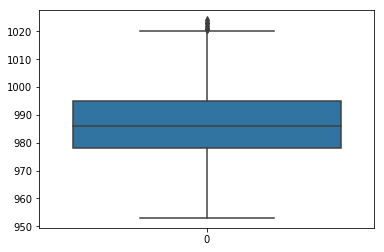

In [34]:
sns.boxplot(data=train.pressure)

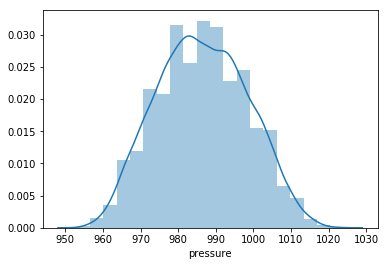

In [35]:
sns.distplot(a=train.pressure,bins=20)

#### Pressure is following almost Normal Distribution.

In [36]:
train.pressure.describe()

count    26496.000000
mean       986.450615
std         12.002647
min        953.000000
25%        978.000000
50%        986.000000
75%        995.000000
max       1024.000000
Name: pressure, dtype: float64

## Windspeed

In [37]:
train.windspeed.describe()

count    26496.000000
mean        23.959956
std         48.280321
min          1.075000
25%          3.155000
50%          6.545000
75%         22.260000
max        586.600000
Name: windspeed, dtype: float64

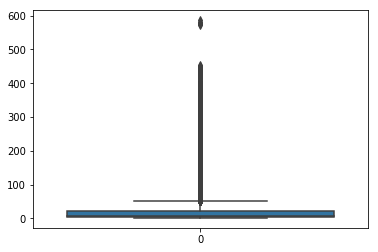

In [39]:
sns.boxplot(data=train.windspeed)

#### Windspeed is highly effected by outliers. So, I created an extra-feature to detect Windspeed Outlier

In [40]:
def Windspeed_Outlier(x):
    if x>10 or x<2:
        return(1)
    else:
        return(0)

In [41]:
train["windspeed_outlier"]=train.windspeed.apply(lambda x: Windspeed_Outlier(x))
test["windspeed_outlier"]=test.windspeed.apply(lambda x: Windspeed_Outlier(x))

In [42]:
train.head()

,ID,day_diff,year,quarter,month,week,dayofyear,day,hour,temperature,var1,pressure,windspeed,var2,electricity_consumption,Q,R,temp_outlier,windspeed_outlier
0,0,0,2013,3,7,27,182,1,0,-11.4,-17.1,1003.0,571.910,A,216.0,0,1,1,1
1,1,0,2013,3,7,27,182,1,1,-12.1,-19.3,996.0,575.040,A,210.0,0,1,1,1
2,2,0,2013,3,7,27,182,1,2,-12.9,-20.0,1000.0,578.435,A,225.0,0,1,1,1
3,3,0,2013,3,7,27,182,1,3,-11.4,-17.1,995.0,582.580,A,216.0,0,1,1,1
4,4,0,2013,3,7,27,182,1,4,-11.4,-19.3,1005.0,586.600,A,222.0,0,1,1,1


In [43]:
test.head()

,ID,day_diff,year,quarter,month,week,dayofyear,day,hour,temperature,var1,pressure,windspeed,var2,Q,R,temp_outlier,windspeed_outlier
0,552,23,2013,3,7,30,205,24,0,-10.0,-16.4,1011.0,263.280,A,0,1,1,1
1,553,23,2013,3,7,30,205,24,1,-10.0,-20.7,1011.0,267.175,A,0,1,1,1
2,554,23,2013,3,7,30,205,24,2,-10.7,-17.1,1003.0,269.555,A,0,1,1,1
3,555,23,2013,3,7,30,205,24,3,-13.6,-20.7,1008.0,273.060,A,0,1,1,1
4,556,23,2013,3,7,30,205,24,4,-10.7,-17.1,1006.0,1.765,A,0,1,1,1


### Var_1

In [44]:
train.var1.describe()

count    26496.000000
mean        -1.916233
std         10.424860
min        -32.900000
25%        -10.700000
50%         -1.400000
75%          7.900000
max         18.600000
Name: var1, dtype: float64

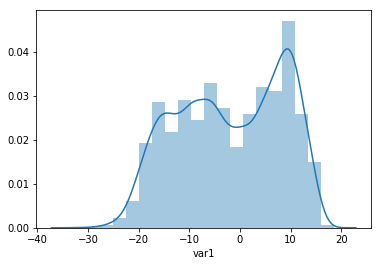

In [45]:
sns.distplot(a=train.var1,bins=20)

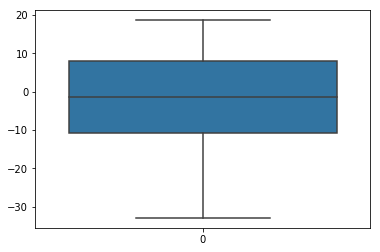

In [46]:
sns.boxplot(data=train.var1)

In [48]:
train.groupby(by=['year','month']).median()['var1']

year  month
2013  7       -17.90
      8       -10.00
      9       -12.90
      10       -5.00
      11        0.00
      12        8.95
2014  1        12.10
      2        12.10
      3         7.10
      4         2.90
      5        -2.90
      6       -13.60
      7       -13.60
      8       -17.10
      9        -9.30
      10       -2.90
      11        2.90
      12        7.90
2015  1        12.10
      2        11.40
      3         6.40
      4         1.40
      5        -5.70
      6       -12.10
      7       -12.90
      8       -12.90
      9        -7.10
      10       -5.70
      11        3.60
      12        8.60
2016  1        11.40
      2        10.70
      3         7.50
      4         0.00
      5        -9.30
      6       -15.00
      7       -15.70
      8       -10.70
      9       -10.70
      10       -2.10
      11        2.10
      12        8.60
2017  1        10.35
      2         9.30
      3         7.90
      4         2.90
      5        -7.10
 

#### Using same concept like temprature,Var1 is categorised in 4 different sections. 

In [49]:
def Var_Category(x):
    p=[1,2]
    q=[3,4,11,12]
    r=[5,9,10]
    s=[6,7,8]
    if x in p:
        return("D")
    elif x in q:
        return("E")
    elif x in r:
        return("F")
    elif x in s:
        return("G")

In [50]:
train=pd.concat([train,pd.get_dummies(train.month.apply(lambda x:Var_Category(x)),drop_first=True)],axis=1)
test=pd.concat([test,pd.get_dummies(test.month.apply(lambda x:Var_Category(x)),drop_first=True)],axis=1)

#### As Var1 is also contains outliers. A new feature is generated to mark the outliers.

In [59]:
def Var1_Outlier(x):
    if x<-15.0 or x>12.5:
        return(1)
    else:
        return(0)

In [60]:
train["var1_outlier"]=train.var1.apply(lambda x: Var1_Outlier(x))
test["var1_outlier"]=test.var1.apply(lambda x: Var1_Outlier(x))


In [31]:
train.head()

,ID,day_diff,year,quarter,month,week,dayofyear,day,hour,temperature,...,var2,electricity_consumption,Q,R,temp_outlier,windspeed_outlier,E,F,G,var1_outlier
0,0,0,2013,3,7,27,182,1,0,-11.4,...,A,216.0,0,1,1,1,0,0,1,1
1,1,0,2013,3,7,27,182,1,1,-12.1,...,A,210.0,0,1,1,1,0,0,1,1
2,2,0,2013,3,7,27,182,1,2,-12.9,...,A,225.0,0,1,1,1,0,0,1,1
3,3,0,2013,3,7,27,182,1,3,-11.4,...,A,216.0,0,1,1,1,0,0,1,1
4,4,0,2013,3,7,27,182,1,4,-11.4,...,A,222.0,0,1,1,1,0,0,1,1


In [32]:
test.head()

,ID,day_diff,year,quarter,month,week,dayofyear,day,hour,temperature,...,windspeed,var2,Q,R,temp_outlier,windspeed_outlier,E,F,G,var1_outlier
0,552,23,2013,3,7,30,205,24,0,-10.0,...,263.280,A,0,1,1,1,0,0,1,1
1,553,23,2013,3,7,30,205,24,1,-10.0,...,267.175,A,0,1,1,1,0,0,1,1
2,554,23,2013,3,7,30,205,24,2,-10.7,...,269.555,A,0,1,1,1,0,0,1,1
3,555,23,2013,3,7,30,205,24,3,-13.6,...,273.060,A,0,1,1,1,0,0,1,1
4,556,23,2013,3,7,30,205,24,4,-10.7,...,1.765,A,0,1,1,1,0,0,1,1


In [25]:
train.shape

(26496, 23)

In [26]:
test.shape

(8568, 22)

## Var 2

#### For var2 normal dummy encoding is used.

In [51]:
train=pd.concat([train,pd.get_dummies(train.var2,drop_first=True)],axis=1)
test=pd.concat([test,pd.get_dummies(test.var2,drop_first=True)],axis=1)

In [52]:
train.head()

,ID,day_diff,year,quarter,month,week,dayofyear,day,hour,temperature,...,electricity_consumption,Q,R,temp_outlier,windspeed_outlier,E,F,G,B,C
0,0,0,2013,3,7,27,182,1,0,-11.4,...,216.0,0,1,1,1,0,0,1,0,0
1,1,0,2013,3,7,27,182,1,1,-12.1,...,210.0,0,1,1,1,0,0,1,0,0
2,2,0,2013,3,7,27,182,1,2,-12.9,...,225.0,0,1,1,1,0,0,1,0,0
3,3,0,2013,3,7,27,182,1,3,-11.4,...,216.0,0,1,1,1,0,0,1,0,0
4,4,0,2013,3,7,27,182,1,4,-11.4,...,222.0,0,1,1,1,0,0,1,0,0


In [53]:
test.head()

,ID,day_diff,year,quarter,month,week,dayofyear,day,hour,temperature,...,var2,Q,R,temp_outlier,windspeed_outlier,E,F,G,B,C
0,552,23,2013,3,7,30,205,24,0,-10.0,...,A,0,1,1,1,0,0,1,0,0
1,553,23,2013,3,7,30,205,24,1,-10.0,...,A,0,1,1,1,0,0,1,0,0
2,554,23,2013,3,7,30,205,24,2,-10.7,...,A,0,1,1,1,0,0,1,0,0
3,555,23,2013,3,7,30,205,24,3,-13.6,...,A,0,1,1,1,0,0,1,0,0
4,556,23,2013,3,7,30,205,24,4,-10.7,...,A,0,1,1,1,0,0,1,0,0


In [54]:
test.shape

(8568, 23)

In [55]:
train.shape

(26496, 24)

In [56]:
train.drop('var2',axis=1,inplace=True)
test.drop('var2',axis=1,inplace=True)

In [57]:
train.columns

Index(['ID', 'day_diff', 'year', 'quarter', 'month', 'week', 'dayofyear',
       'day', 'hour', 'temperature', 'var1', 'pressure', 'windspeed',
       'electricity_consumption', 'Q', 'R', 'temp_outlier',
       'windspeed_outlier', 'E', 'F', 'G', 'B', 'C'],
      dtype='object')

In [61]:
train=train[['ID', 'day_diff', 'year', 'quarter', 'month', 'week', 'dayofyear',
       'day', 'hour','temperature','Q','R','temp_outlier','var1','E','F','G','var1_outlier','pressure','windspeed',
       'windspeed_outlier','B','C','electricity_consumption']]

In [62]:
test=test[['ID', 'day_diff', 'year', 'quarter', 'month', 'week', 'dayofyear',
       'day', 'hour','temperature','Q','R','temp_outlier','var1','E','F','G','var1_outlier','pressure','windspeed',
       'windspeed_outlier','B','C']]

#### Saving Cleaned Data for further use.

In [54]:
train.to_csv("Cleaned_Train.csv",index=False)
test.to_csv("Cleaned_Test.csv",index=False)

## Modelling

In [63]:
X=train.iloc[:,1:-1]
y=train['electricity_consumption']

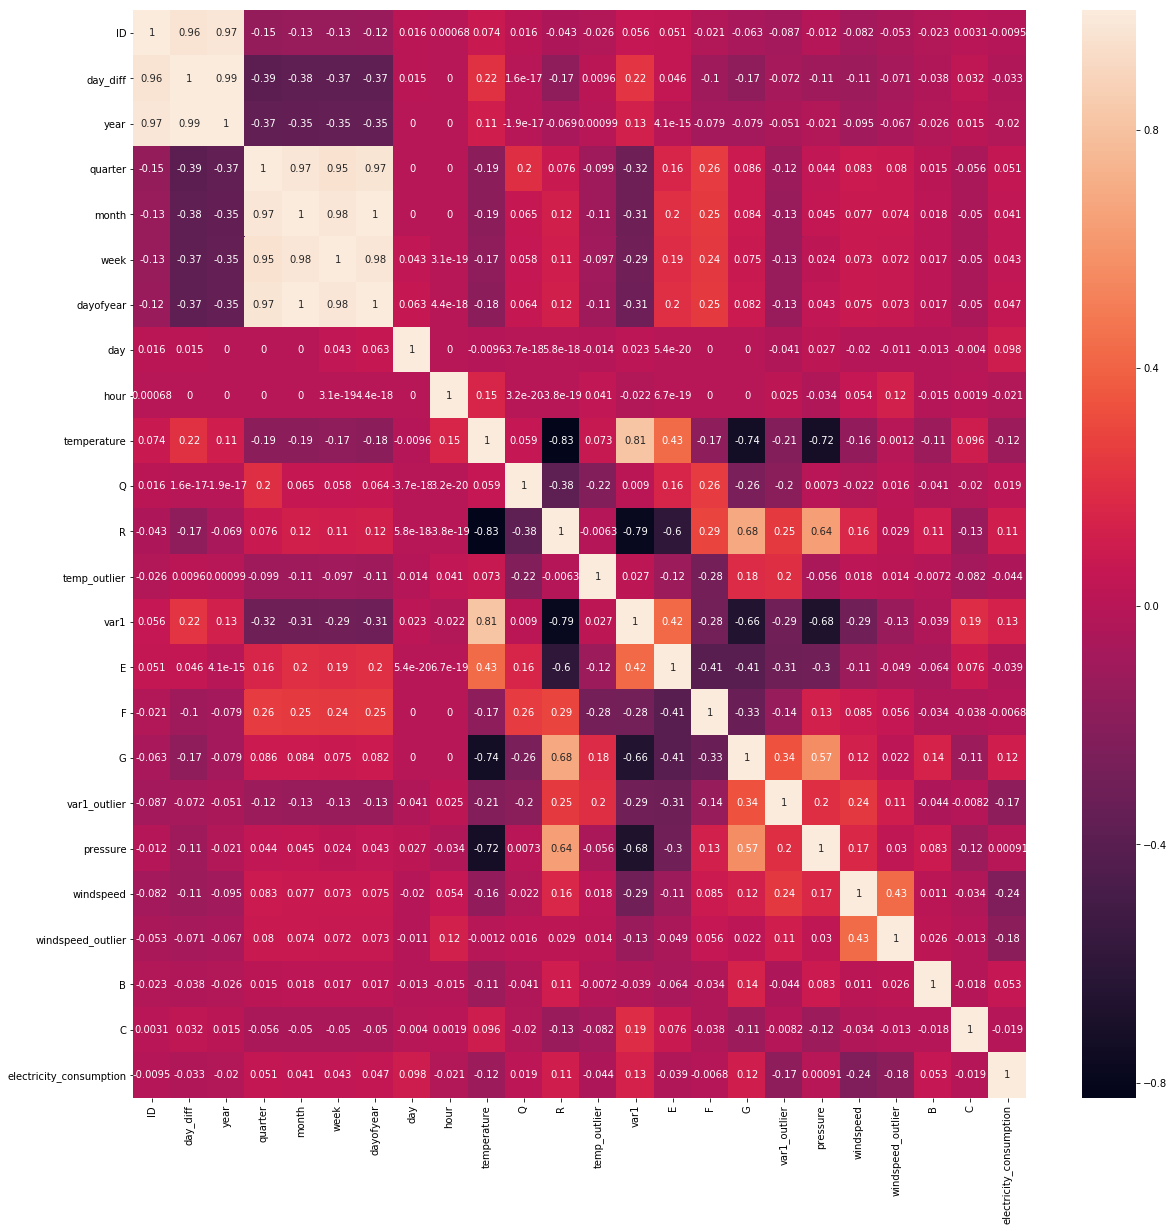

In [64]:
#Co-relation Plot
plt.figure(figsize=(20,20))
sns.heatmap(train.corr(),annot=True)

In [65]:
from sklearn.model_selection import train_test_split,cross_val_score

In [66]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [67]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()

In [68]:
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

### Random_Forest_Model

In [72]:
from sklearn.ensemble import RandomForestRegressor

In [73]:
model_RF=RandomForestRegressor(n_estimators=500,max_features='auto',min_samples_leaf=10,n_jobs=-1)

In [74]:
## Scoring Function
def Score(model,X_train,y_train,X_test,y_test,train=True):
    from sklearn.metrics import mean_squared_error
    if train==True:
        print("Training Result \n")
        print("RMSE Value:  {0:0.4f} \n".format(np.sqrt(mean_squared_error(y_train,model.predict(X_train)))))
        scores=cross_val_score(estimator=model,X=X_train,y=y_train,cv=15,scoring="neg_mean_squared_error",n_jobs=-1)
        print("Cross-Validation Score:",(np.sqrt(scores*(-1))).mean())
        print("Standard Deviation: \n",(np.sqrt(scores*(-1))).std())
    elif train==False:
        print("TestResult \n")
        print("RMSE Value:  {0:0.4f} \n".format(np.sqrt(mean_squared_error(y_test,model.predict(X_test)))))
        

In [75]:
model_RF.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [77]:
Score(model_RF,X_train,y_train,X_test,y_test,train=True)

Training Result 

RMSE Value:  48.9888 

Cross-Validation Score: 59.3859295517
Standard Deviation: 
 2.69885158562


In [76]:
Score(model_RF,X_train,y_train,X_test,y_test,train=False)

TestResult 

RMSE Value:  57.7391 



In [78]:
pred_RF=model_RF.predict(test.iloc[:,1:])

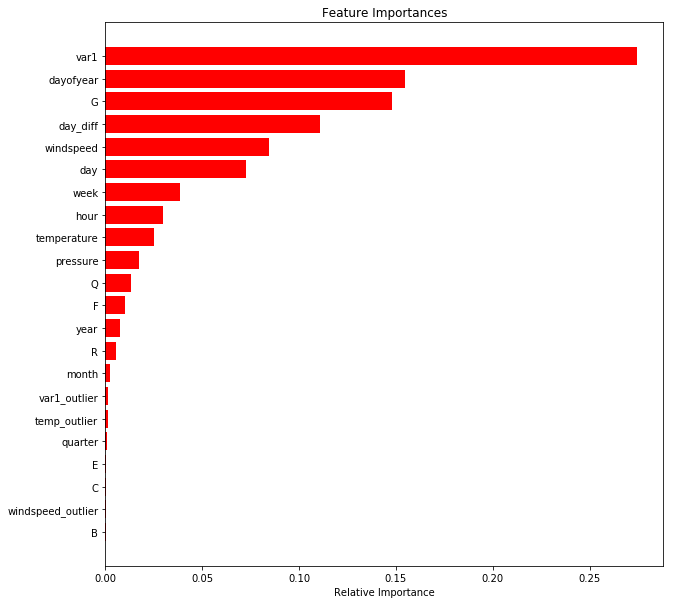

In [79]:
plt.figure(figsize=(10,10))
features =X.columns
importances = model_RF.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

### Random Forest Optimization Parameters

In [80]:
param_grid={
            "n_estimators":[100,150,200,300,500],
            "max_features":["auto",0.1,0.2,0.3,0.5],
            "min_samples_leaf":[10,20,30,50]
           }

### Submission RF

In [81]:
## Submission
submission=pd.read_csv("sample_submission_q0Q3I1Z.csv")
submission.ID=test.ID
submission.electricity_consumption=pred_RF
submission.to_csv("Submission_RF.csv",index=False)

### XGBoost Model

In [82]:
train.head()

,ID,day_diff,year,quarter,month,week,dayofyear,day,hour,temperature,...,E,F,G,var1_outlier,pressure,windspeed,windspeed_outlier,B,C,electricity_consumption
0,0,0,2013,3,7,27,182,1,0,-11.4,...,0,0,1,1,1003.0,571.910,1,0,0,216.0
1,1,0,2013,3,7,27,182,1,1,-12.1,...,0,0,1,1,996.0,575.040,1,0,0,210.0
2,2,0,2013,3,7,27,182,1,2,-12.9,...,0,0,1,1,1000.0,578.435,1,0,0,225.0
3,3,0,2013,3,7,27,182,1,3,-11.4,...,0,0,1,1,995.0,582.580,1,0,0,216.0
4,4,0,2013,3,7,27,182,1,4,-11.4,...,0,0,1,1,1005.0,586.600,1,0,0,222.0


In [92]:
X_train,X_test,y_train,y_test=train_test_split(train.iloc[:,1:-1],train.iloc[:,-1],test_size=0.2,random_state=42)

In [93]:
from xgboost import XGBRegressor
model_XGB=XGBRegressor(learning_rate=0.1,n_estimators=500,max_depth=10,colsample_bytree=0.5)
model_XGB.fit(X_train,y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.5,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=500, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [94]:
pred_XGB=model_XGB.predict((test.iloc[:,1:]))

In [95]:
## Submission
submission=pd.read_csv("sample_submission_q0Q3I1Z.csv")
submission.ID=test.ID
submission.electricity_consumption=pred_XGB
submission.to_csv("Submission_XGB_500.csv",index=False)

### Catboost

In [180]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
#import tensorflow
#import seaborn as sns
#import xgboost
import catboost
#import lightgbm
#import keras

In [215]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

### Special Preprocessing for Catboost Model

In [216]:
train.datetime=pd.to_datetime(train.datetime)
test.datetime=pd.to_datetime(test.datetime)

train["year"]=train.datetime.apply(lambda x: x.year)
train["month"]=train.datetime.apply(lambda x: x.month)
train["week"]=train.datetime.apply(lambda x: x.week)
train["day"]=train.datetime.apply(lambda x: x.day)
train["hour"]=train.datetime.apply(lambda x: x.hour)
train["quarter"]=train.datetime.apply(lambda x: x.quarter)
train["dayofyear"]=train.datetime.apply(lambda x: x.dayofyear)
train["day_diff"]=np.abs((2013-train.datetime.dt.year)*365)+np.abs((7-train.datetime.dt.month)*30)+np.abs((1-train.datetime.dt.day))

test["year"]=test.datetime.apply(lambda x: x.year)
test["month"]=test.datetime.apply(lambda x: x.month)
test["week"]=test.datetime.apply(lambda x: x.week)
test["day"]=test.datetime.apply(lambda x: x.day)
test["hour"]=test.datetime.apply(lambda x: x.hour)
test["quarter"]=test.datetime.apply(lambda x: x.quarter)
test["dayofyear"]=test.datetime.apply(lambda x: x.dayofyear)
test["day_diff"]=np.abs((2013-test.datetime.dt.year)*365)+np.abs((7-test.datetime.dt.month)*30)+np.abs((1-test.datetime.dt.day))


train=train[["ID","day_diff","year","quarter",'month','week',"dayofyear",'day','hour','temperature','var1','pressure','windspeed','var2','electricity_consumption']]
test=test[["ID","day_diff","year","quarter",'month','week','dayofyear','day','hour','temperature','var1','pressure','windspeed','var2']]

In [217]:
## Temperature Category 

def Temp_Category(x):
    p=[11,12,1,2,3]
    q=[4,10]
    r=[5,6,7,8,9]
    if x in p:
        return("P")
    elif x in q:
        return("Q")
    elif x in r:
        return("R")

In [218]:
train['temp_cat']=train.month.apply(lambda x: Temp_Category(x))

In [219]:
test['temp_cat']=test.month.apply(lambda x: Temp_Category(x))

In [220]:
def Temp_Outlier(x):
    if x>15.0 or x<-7.5:
        return(1)
    else:
        return(0)

train["temp_outlier"]=train.temperature.apply(lambda x: Temp_Outlier(x))
test["temp_outlier"]=test.temperature.apply(lambda x: Temp_Outlier(x))

In [221]:
def Windspeed_Outlier(x):
    if x>10 or x<2:
        return(1)
    else:
        return(0)

train["windspeed_outlier"]=train.windspeed.apply(lambda x: Windspeed_Outlier(x))
test["windspeed_outlier"]=test.windspeed.apply(lambda x: Windspeed_Outlier(x))


In [222]:
def Var_Category(x):
    p=[1,2]
    q=[3,4,11,12]
    r=[5,9,10]
    s=[6,7,8]
    if x in p:
        return("D")
    elif x in q:
        return("E")
    elif x in r:
        return("F")
    elif x in s:
        return("G")
train['var1_cat']=train.month.apply(lambda x:Var_Category(x))
test['var1_cat']=test.month.apply(lambda x:Var_Category(x))

In [223]:
def Var1_Outlier(x):
    if x<-15.0 or x>12.5:
        return(1)
    else:
        return(0)

train["var1_outlier"]=train.var1.apply(lambda x: Var1_Outlier(x))
test["var1_outlier"]=test.var1.apply(lambda x: Var1_Outlier(x))


In [225]:
train.head()

,ID,day_diff,year,quarter,month,week,dayofyear,day,hour,temperature,var1,pressure,windspeed,var2,electricity_consumption,temp_cat,temp_outlier,windspeed_outlier,var1_cat,var1_outlier
0,0,0,2013,3,7,27,182,1,0,-11.4,-17.1,1003.0,571.910,A,216.0,R,1,1,G,1
1,1,0,2013,3,7,27,182,1,1,-12.1,-19.3,996.0,575.040,A,210.0,R,1,1,G,1
2,2,0,2013,3,7,27,182,1,2,-12.9,-20.0,1000.0,578.435,A,225.0,R,1,1,G,1
3,3,0,2013,3,7,27,182,1,3,-11.4,-17.1,995.0,582.580,A,216.0,R,1,1,G,1
4,4,0,2013,3,7,27,182,1,4,-11.4,-19.3,1005.0,586.600,A,222.0,R,1,1,G,1


In [226]:
test.head()

,ID,day_diff,year,quarter,month,week,dayofyear,day,hour,temperature,var1,pressure,windspeed,var2,temp_cat,temp_outlier,windspeed_outlier,var1_cat,var1_outlier
0,552,23,2013,3,7,30,205,24,0,-10.0,-16.4,1011.0,263.280,A,R,1,1,G,1
1,553,23,2013,3,7,30,205,24,1,-10.0,-20.7,1011.0,267.175,A,R,1,1,G,1
2,554,23,2013,3,7,30,205,24,2,-10.7,-17.1,1003.0,269.555,A,R,1,1,G,1
3,555,23,2013,3,7,30,205,24,3,-13.6,-20.7,1008.0,273.060,A,R,1,1,G,1
4,556,23,2013,3,7,30,205,24,4,-10.7,-17.1,1006.0,1.765,A,R,1,1,G,1


In [207]:
train.columns

Index(['ID', 'day_diff', 'year', 'quarter', 'month', 'week', 'dayofyear',
       'day', 'hour', 'temperature', 'var1', 'pressure', 'windspeed', 'var2',
       'electricity_consumption', 'temp_cat', 'temp_outlier',
       'windspeed_outlier', 'var1_cat', 'var1_outlier'],
      dtype='object')

In [227]:
train=train[['ID', 'day_diff', 'year', 'quarter', 'month', 'week', 'dayofyear',
       'day', 'hour', 'temperature','temp_cat', 'temp_outlier','var1','var1_cat', 'var1_outlier','pressure',
        'windspeed','windspeed_outlier','var2','electricity_consumption']]

In [228]:
test=test[['ID', 'day_diff', 'year', 'quarter', 'month', 'week', 'dayofyear',
       'day', 'hour', 'temperature','temp_cat', 'temp_outlier','var1','var1_cat', 'var1_outlier','pressure',
        'windspeed','windspeed_outlier','var2']]

In [229]:
train.dtypes

ID                           int64
day_diff                     int64
year                         int64
quarter                      int64
month                        int64
week                         int64
dayofyear                    int64
day                          int64
hour                         int64
temperature                float64
temp_cat                    object
temp_outlier                 int64
var1                       float64
var1_cat                    object
var1_outlier                 int64
pressure                   float64
windspeed                  float64
windspeed_outlier            int64
var2                        object
electricity_consumption    float64
dtype: object

In [232]:
cat_index=np.where(train.dtypes == 'object')[0]

In [231]:
np.where(test.dtypes == 'object')[0]

array([10, 13, 18])

In [242]:
X_train.shape

(18547, 18)

In [250]:
X_train,X_test,y_train,y_test=train_test_split(train.iloc[:,1:-1],train.iloc[:,-1],test_size=0.2,random_state=42)

In [234]:
from catboost import CatBoostRegressor

In [251]:
model=CatBoostRegressor(iterations=500, depth=3, learning_rate=0.1, loss_function='RMSE')

In [252]:
model.fit(X_train, y_train,cat_features=[9,12,17],eval_set=(X_test, y_test),plot=True)

0:	learn: 289.2861462	test: 289.0671569	best: 289.0671569 (0)	total: 23ms	remaining: 11.5s
1:	learn: 264.5556746	test: 264.3017210	best: 264.3017210 (1)	total: 41.8ms	remaining: 10.4s
2:	learn: 242.2606591	test: 241.8910499	best: 241.8910499 (2)	total: 58.3ms	remaining: 9.65s
3:	learn: 222.6795075	test: 222.2799226	best: 222.2799226 (3)	total: 78.1ms	remaining: 9.68s
4:	learn: 205.6719670	test: 205.2331720	best: 205.2331720 (4)	total: 90.8ms	remaining: 8.99s
5:	learn: 189.8369171	test: 189.4160651	best: 189.4160651 (5)	total: 127ms	remaining: 10.5s
6:	learn: 176.3673084	test: 175.8814466	best: 175.8814466 (6)	total: 149ms	remaining: 10.5s
7:	learn: 164.7602116	test: 164.2066403	best: 164.2066403 (7)	total: 168ms	remaining: 10.3s
8:	learn: 154.5025443	test: 153.9541383	best: 153.9541383 (8)	total: 186ms	remaining: 10.1s
9:	learn: 145.4613112	test: 144.8533887	best: 144.8533887 (9)	total: 203ms	remaining: 9.97s
10:	learn: 137.8070656	test: 137.2384841	best: 137.2384841 (10)	total: 221ms	

A Jupyter Widget

36:	learn: 89.9650017	test: 90.0214667	best: 90.0214667 (36)	total: 757ms	remaining: 9.48s
37:	learn: 89.7420622	test: 89.8082188	best: 89.8082188 (37)	total: 787ms	remaining: 9.57s
38:	learn: 89.4654973	test: 89.5529636	best: 89.5529636 (38)	total: 809ms	remaining: 9.57s
39:	learn: 89.0589438	test: 89.1902098	best: 89.1902098 (39)	total: 831ms	remaining: 9.55s
40:	learn: 88.8514750	test: 88.9679545	best: 88.9679545 (40)	total: 853ms	remaining: 9.55s
41:	learn: 88.6176727	test: 88.7405131	best: 88.7405131 (41)	total: 876ms	remaining: 9.55s
42:	learn: 88.1500203	test: 88.3335263	best: 88.3335263 (42)	total: 899ms	remaining: 9.56s
43:	learn: 87.6267551	test: 87.8509107	best: 87.8509107 (43)	total: 921ms	remaining: 9.55s
44:	learn: 87.3475446	test: 87.5613617	best: 87.5613617 (44)	total: 943ms	remaining: 9.54s
45:	learn: 87.0352689	test: 87.2508852	best: 87.2508852 (45)	total: 971ms	remaining: 9.58s
46:	learn: 86.7567515	test: 87.0009078	best: 87.0009078 (46)	total: 994ms	remaining: 9.58s

In [249]:
Score(model,X_train,y_train,X_test,y_test,train=False)

TestResult 

RMSE Value:  69.1294 



In [137]:
pred_CAT=model_CAT.predict(sc.transform(test.iloc[:,1:]))

### CatBoost Grid Search

In [254]:
params = {
          'depth':[3,1,2,6,4,5,7,8,9,10],
          'iterations':[250,100,500,1000],
          'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
          'l2_leaf_reg':[3,1,5,10],
          }

### Submission

In [77]:
pred_RF=model_RF.predict(sc.transform(test.iloc[:,1:]))

In [79]:
submission=pd.read_csv("sample_submission_q0Q3I1Z.csv")
submission.ID=test.ID
submission.electricity_consumption=pred_RF
submission.to_csv("PRED_RF_1.csv",index=False)

## Final Model

### Finally, XGBoost model is submitted for final submission.